Notebook to carry out a fit of an IC model to the HESS spectrum of 
[RX J1713.7-3946](http://tevcat.uchicago.edu/?mode=1;id=84) with the naima wrapper around [emcee](http://dfm.io/emcee). This tutorial will follow loosely the tutorial found on the [naima documentation](http://naima.readthedocs.org/en/latest/tutorial.html).

The first step is to load the data, which we can find in the same directory as this notebook. The data format required by naima for the data files can be found in the documentation.


The we define the model to be fit. The model function must take a tuple of free parameters as first argument and a data table as second. It must return the model flux at the energies given by ```python
data['energy']``` in first place, and any extra objects will be saved with the MCMC chain.

emcee does not accept astropy Quantities as parameters, so we have to give them units before setting the attributes of the particle distribution function.

Here we define an IC model with an Exponential Cutoff Power-Law with the amplitude, index, and cutoff energy as free parameters. Because the amplitude and cutoff energy may be considered to have a uniform prior in log-space, we sample their decimal logarithms (we could also use a log-uniform prior). We also place a uniform prior on the particle index with limits between -1 and 5.


In [3]:
!pip install naima

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 12.9 MB/s eta 0:00:00m eta 0:00:01:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 19.7 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.5 MB/s eta 0:00:000:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.5/739.5 kB 17.1 MB/s eta 0:00:00m eta 0:00:01


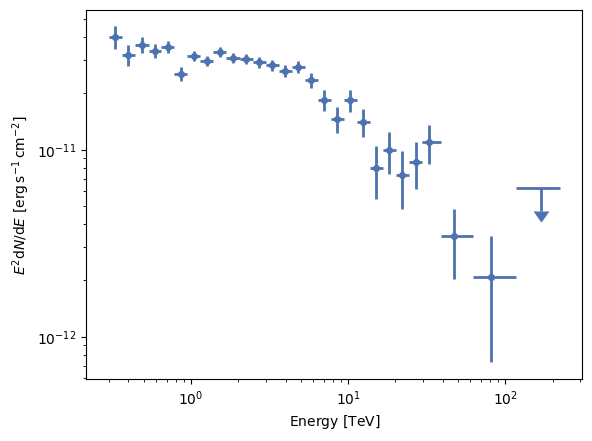

In [4]:

import naima
import numpy as np
from astropy.io import ascii
import astropy.units as u
%matplotlib inline
import matplotlib.pyplot as plt

hess_spectrum = ascii.read('RXJ1713_HESS_2007.dat', format='ipac')
fig = naima.plot_data(hess_spectrum)



In [5]:
from naima.models import ExponentialCutoffPowerLaw, InverseCompton
from naima import uniform_prior

ECPL = ExponentialCutoffPowerLaw(1e36/u.eV, 5*u.TeV, 2.7, 50*u.TeV)
IC = InverseCompton(ECPL, seed_photon_fields=['CMB', ['FIR', 30*u.K, 0.4*u.eV/u.cm**3]])

# define labels and initial vector for the parameters
labels = ['log10(norm)', 'index', 'log10(cutoff)']
p0 = np.array((34, 2.7, np.log10(30)))

# define the model function
def model(pars, data):
    ECPL.amplitude = (10**pars[0]) / u.eV
    ECPL.alpha = pars[1]
    ECPL.e_cutoff = (10**pars[2]) * u.TeV

    return IC.flux(data['energy'], distance=2.0*u.kpc), IC.compute_We(Eemin=1*u.TeV)

from naima import uniform_prior

def lnprior(pars):
    lnprior = uniform_prior(pars[1], -1, 5)
    return lnprior



We take the data, model, prior, parameter vector, and labels and call the main fitting procedure: naima.run_sampler. This function is a wrapper around emcee, and the details of the MCMC run can be configured through its arguments:

```python nwalkers```: number of emcee walkers.

```python nburn```: number of steps to take for the burn-in period. These steps will be discarded in the final results. 
```python nrun```: number of steps to take and save to the sampler chain.

```python prefit```: whether to do a Nelder-Mead fit before starting the MCMC run (reduces the burn-in steps required).

```python interactive```:  whether to launch an interactive model fitter before starting the run to set the initial vector. 
   This will only work in matplotlib is using a GUI backend (qt4, qt5, gtkagg, tkagg, etc.). The final parameters when you close the window will be used as starting point for the run.
    threads: How many different threads (CPU cores) to use when computing the likelihood.



In [6]:
sampler, pos = naima.run_sampler(data_table=hess_spectrum, model=model, prior=lnprior, p0=p0, labels=labels,
                                nwalkers=32, nburn=50, nrun=100, prefit=True, threads=4)


INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [33.70675951  2.7         1.47712125] [naima.core]
INFO:    Initial lnprob(p0): -79.129 [naima.core]
INFO:    New ML parameters : [33.52921128  2.45802763  1.58501849] [naima.core]
INFO:    Maximum lnprob(p0): -18.589 [naima.core]
Burning in the 32 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      33.5            2.46            1.59      
  Last ensemble std    :      0.162           0.015          0.00805    
  Last ensemble lnprob :  avg: -445.526, max: -18.656

Progress of the run: 10 percent (5 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      33.5            2.46            1.58      
  Last ensemble std    :      0.09            0.015          0.00752    
  Last ensemble 


Progress of the run: 70 percent (70 of 100 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      33.5            2.55            1.68      
  Last ensemble std    :     0.0161          0.0985          0.0953     
  Last ensemble lnprob :  avg: -19.506, max: -18.023

Progress of the run: 75 percent (75 of 100 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      33.5            2.55            1.66      
  Last ensemble std    :     0.0166           0.113           0.128     
  Last ensemble lnprob :  avg: -19.471, max: -18.146

Progress of the run: 80 percent (80 of 100 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      33.5            2.58            1.69      
  Last ensemble std    :     0.0162          0.0975           0.117     
  Last ensemble lnprob :  avg: -19.705, max: -18.079

Progress of the run: 85 

INFO: -------------------log10(norm)--------------------
          log10(norm) = $33.532 \pm 0.017$
                 norm = $(3.40 \pm 0.13)\times10^{33}$ [naima.plot]
INFO: ----------------------index-----------------------
          index = $2.54 \pm 0.11$ [naima.plot]
INFO: ------------------log10(cutoff)-------------------
          log10(cutoff) = $1.66^{+0.12}_{-0.09}$
                 cutoff = $46^{+15}_{-9}$ [naima.plot]


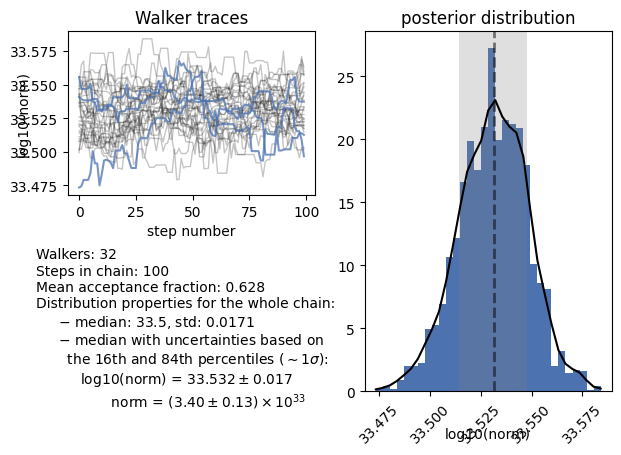

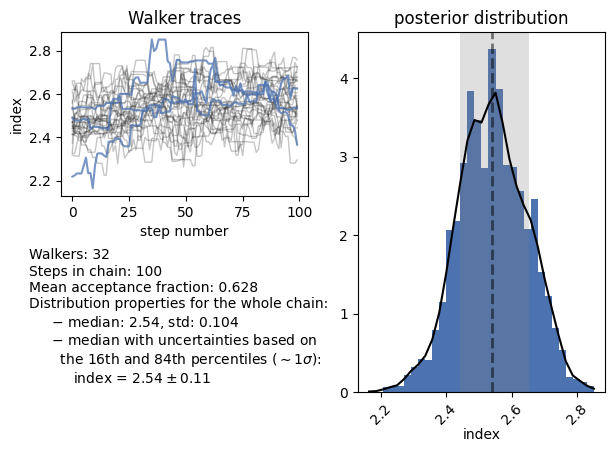

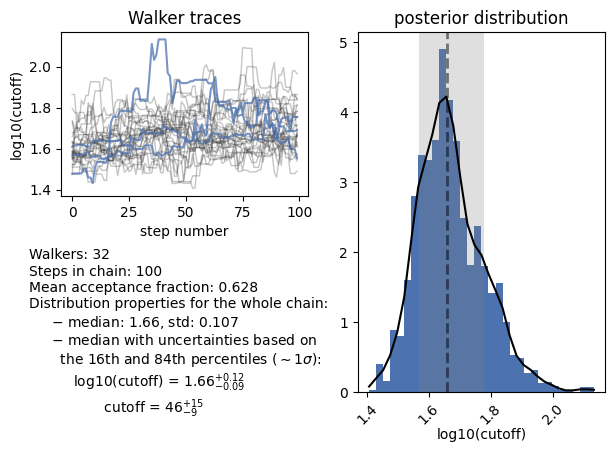

In [7]:
# inspect the chains stored in the sampler for the three free parameters
f = naima.plot_chain(sampler, 0)
f = naima.plot_chain(sampler, 1)
f = naima.plot_chain(sampler, 2)

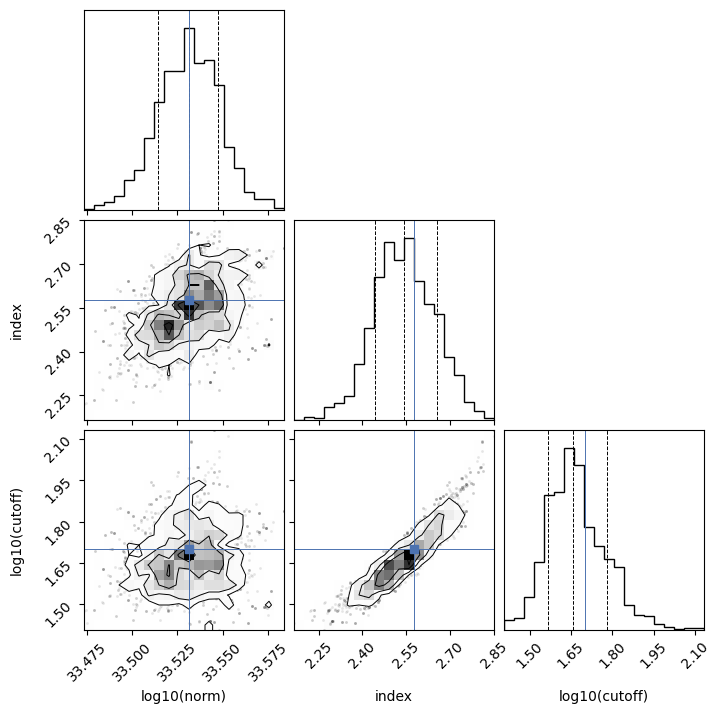

In [8]:
# make a corner plot of the parameters to show covariances
f = naima.plot_corner(sampler)

(1e-13, 6.312391655801442e-11)

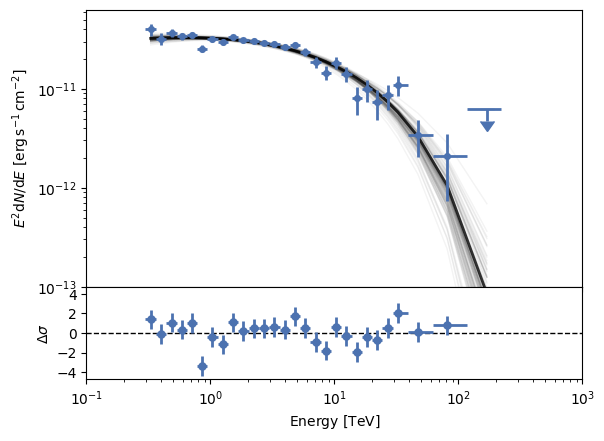

In [9]:
# Show the fit
f = naima.plot_fit(sampler)
f.axes[0].set_ylim(bottom=1e-13)


Simultaneous fitting of two radiative components: Synchrotron and IC.

Use the Suzaku XIS spectrum of RX J1713 to do a simultaneous fit of the synchrotron and inverse Compton spectra and derive an estimate of the magnetic field strength under the assumption of a leptonic scenario.


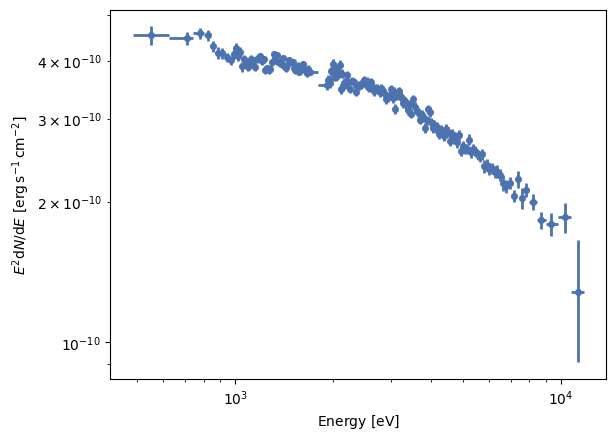

In [10]:
suzaku_spectrum = ascii.read('RXJ1713_Suzaku-XIS.dat')
f=naima.plot_data(suzaku_spectrum)

Note that in all naima functions (including run_sampler) you can provide a list of spectra, so you can consider both the HESS and Suzaku spectra:

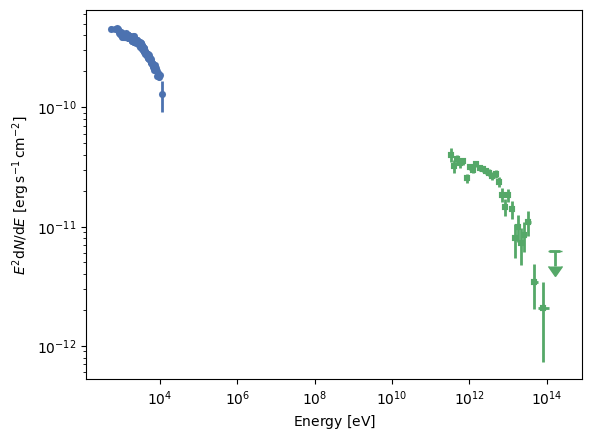

In [11]:
f=naima.plot_data([suzaku_spectrum, hess_spectrum], sed=True)

Below is the model, labels, parameters and prior defined above for the IC-only fit. Modify it as needed and feed it to naima.run_sampler to obtain an estimate of the magnetic field strength.

In [12]:
#from naima.models import ExponentialCutoffPowerLaw, InverseCompton
#from naima import uniform_prior

#ECPL = ExponentialCutoffPowerLaw(1e36/u.eV, 10*u.TeV, 2.7, 50*u.TeV)
#IC = InverseCompton(ECPL, seed_photon_fields=['CMB', ['FIR', 30*u.K, 0.4*u.eV/u.cm**3]])

## define labels and initial vector for the parameters
#labels = ['log10(norm)', 'index', 'log10(cutoff)']
#p0 = np.array((34, 2.7, np.log10(30)))

## define the model function
#def model(pars, data):
#    ECPL.amplitude = (10**pars[0]) / u.eV
#    ECPL.alpha = pars[1]
#    ECPL.e_cutoff = (10**pars[2]) * u.TeV

#    return IC.flux(data['energy'], distance=2.0*u.kpc), IC.compute_We(Eemin=1*u.TeV)

#from naima import uniform_prior

#def lnprior(pars):
#    lnprior = uniform_prior(pars[1], -1, 5)
#    return lnprior